Importing Relevant Libraries

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier 


Loading the datasets

In [135]:

crashes = pd.read_csv("./data/Traffic_Crashes_-_Crashes.csv.gz")
people = pd.read_csv("./data/Traffic_Crashes_-_People.csv.gz")
vehicles = pd.read_csv("./data/Traffic_Crashes_-_Vehicles.csv.gz")


c:\Users\sharo\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\Users\sharo\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (20,39,40,41,47,48,49,57,58,60) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [136]:
print(crashes.shape)
crashes.columns


(54959, 48)


Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [137]:
print(people.shape)
people.columns


(120061, 29)


Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

In [138]:
print(vehicles.shape)
vehicles.columns

(111727, 71)


Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

In [139]:
# 2. Create the SQL Engine in Memory (RAM)
conn = sqlite3.connect(':memory:')


In [140]:

# 3. Upload data to SQL (This takes a few seconds)
crashes.to_sql('Traffic_Crashes_Crashes', conn, index=False, if_exists='replace')
people.to_sql('Traffic_Crashes_People', conn, index=False, if_exists='replace')
vehicles.to_sql('Traffic_Crashes_Vehicles', conn, index=False, if_exists='replace')


c:\Users\sharo\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [141]:

# 4. Paste the Query String
query = """SELECT 
    c.CRASH_RECORD_ID,
    c.PRIM_CONTRIBUTORY_CAUSE,   
    c.CRASH_HOUR,
    c.CRASH_DAY_OF_WEEK,
    c.CRASH_MONTH,
    c.POSTED_SPEED_LIMIT,
    c.WEATHER_CONDITION,
    c.LIGHTING_CONDITION,
    c.ROADWAY_SURFACE_COND,
    c.ROAD_DEFECT,
    c.TRAFFIC_CONTROL_DEVICE,
    c.FIRST_CRASH_TYPE,
    COALESCE(p.TOTAL_PEOPLE, 0) AS TOTAL_PEOPLE,
    p.AGE,
    COALESCE(p.DRUNK_DRIVERS_COUNT, 0) AS DRUNK_DRIVERS_COUNT,
    COALESCE(v.TOTAL_VEHICLES, 0) AS TOTAL_VEHICLES,
    COALESCE(v.DEFECTIVE_VEHICLES_COUNT, 0) AS DEFECTIVE_VEHICLES_COUNT

FROM Traffic_Crashes_Crashes c
LEFT JOIN (
    SELECT 
        CRASH_RECORD_ID,
        COUNT(PERSON_ID) AS TOTAL_PEOPLE,
        MAX(AGE) AS AGE,
        SUM(CASE WHEN PHYSICAL_CONDITION LIKE '%ALCOHOL%' THEN 1 ELSE 0 END) AS DRUNK_DRIVERS_COUNT
    FROM Traffic_Crashes_People
    GROUP BY CRASH_RECORD_ID
) p ON c.CRASH_RECORD_ID = p.CRASH_RECORD_ID
LEFT JOIN (
    SELECT 
        CRASH_RECORD_ID,
        COUNT(VEHICLE_ID) AS TOTAL_VEHICLES,
        SUM(CASE WHEN VEHICLE_DEFECT NOT IN ('NONE', 'UNKNOWN') THEN 1 ELSE 0 END) AS DEFECTIVE_VEHICLES_COUNT
    FROM Traffic_Crashes_Vehicles
    GROUP BY CRASH_RECORD_ID
) v ON c.CRASH_RECORD_ID = v.CRASH_RECORD_ID;
"""


aggregate, vehicles, 

In [142]:

# 5. Execute and get your Clean Dataset
data = pd.read_sql_query(query, conn)


In [143]:
data.shape

(54959, 17)

In [144]:
data.columns

Index(['CRASH_RECORD_ID', 'PRIM_CONTRIBUTORY_CAUSE', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'TRAFFIC_CONTROL_DEVICE', 'FIRST_CRASH_TYPE',
       'TOTAL_PEOPLE', 'AGE', 'DRUNK_DRIVERS_COUNT', 'TOTAL_VEHICLES',
       'DEFECTIVE_VEHICLES_COUNT'],
      dtype='object')

In [145]:
data.isnull().sum()

CRASH_RECORD_ID                0
PRIM_CONTRIBUTORY_CAUSE        0
CRASH_HOUR                     0
CRASH_DAY_OF_WEEK              0
CRASH_MONTH                    0
POSTED_SPEED_LIMIT             0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
TRAFFIC_CONTROL_DEVICE         0
FIRST_CRASH_TYPE               0
TOTAL_PEOPLE                   0
AGE                         9219
DRUNK_DRIVERS_COUNT            0
TOTAL_VEHICLES                 0
DEFECTIVE_VEHICLES_COUNT       0
dtype: int64

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CRASH_RECORD_ID           54959 non-null  object 
 1   PRIM_CONTRIBUTORY_CAUSE   54959 non-null  object 
 2   CRASH_HOUR                54959 non-null  int64  
 3   CRASH_DAY_OF_WEEK         54959 non-null  int64  
 4   CRASH_MONTH               54959 non-null  int64  
 5   POSTED_SPEED_LIMIT        54959 non-null  int64  
 6   WEATHER_CONDITION         54959 non-null  object 
 7   LIGHTING_CONDITION        54959 non-null  object 
 8   ROADWAY_SURFACE_COND      54959 non-null  object 
 9   ROAD_DEFECT               54959 non-null  object 
 10  TRAFFIC_CONTROL_DEVICE    54959 non-null  object 
 11  FIRST_CRASH_TYPE          54959 non-null  object 
 12  TOTAL_PEOPLE              54959 non-null  int64  
 13  AGE                       45740 non-null  float64
 14  DRUNK_

In [147]:
median_age = data['AGE'].median()
data['AGE'] = data['AGE'].fillna(median_age)

In [148]:
data["AGE"].astype(np.int64)

0        40
1        45
2        54
3        74
4        39
         ..
54954    28
54955    29
54956    39
54957    63
54958    37
Name: AGE, Length: 54959, dtype: int64

In [149]:
data.isnull().sum()

CRASH_RECORD_ID             0
PRIM_CONTRIBUTORY_CAUSE     0
CRASH_HOUR                  0
CRASH_DAY_OF_WEEK           0
CRASH_MONTH                 0
POSTED_SPEED_LIMIT          0
WEATHER_CONDITION           0
LIGHTING_CONDITION          0
ROADWAY_SURFACE_COND        0
ROAD_DEFECT                 0
TRAFFIC_CONTROL_DEVICE      0
FIRST_CRASH_TYPE            0
TOTAL_PEOPLE                0
AGE                         0
DRUNK_DRIVERS_COUNT         0
TOTAL_VEHICLES              0
DEFECTIVE_VEHICLES_COUNT    0
dtype: int64

In [150]:
data.head()

,CRASH_RECORD_ID,PRIM_CONTRIBUTORY_CAUSE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,TRAFFIC_CONTROL_DEVICE,FIRST_CRASH_TYPE,TOTAL_PEOPLE,AGE,DRUNK_DRIVERS_COUNT,TOTAL_VEHICLES,DEFECTIVE_VEHICLES_COUNT
0,d4532856f89a7311fb6182ffef7cd3c27fdba4dba40671...,DISREGARDING TRAFFIC SIGNALS,23,3,12,35,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,TRAFFIC SIGNAL,ANGLE,2,40.0,0,2,0
1,b938fbfa86d8b2d58d26656bf3266bc5452af63bd100ad...,UNABLE TO DETERMINE,23,3,12,30,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,UNKNOWN,FIXED OBJECT,1,45.0,0,1,0
2,bb8c152ed4e0d29961e051b7d381508f1f9ea5aa051dbe...,UNABLE TO DETERMINE,22,3,12,30,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SIDESWIPE SAME DIRECTION,2,54.0,0,2,0
3,40064b1f9d498293c9392d4c89bb60128409738a3c44d1...,DISREGARDING STOP SIGN,22,3,12,35,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,STOP SIGN/FLASHER,ANGLE,4,74.0,0,2,0
4,efce3ab254c9daaacb6ce6a60e10e8cb8ca50ab3f7ea5b...,UNABLE TO DETERMINE,22,3,12,30,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,TRAFFIC SIGNAL,TURNING,2,39.0,0,2,0


In [151]:
data["ROAD_DEFECT"].unique()

array(['NO DEFECTS', 'UNKNOWN', 'WORN SURFACE', 'OTHER',
       'DEBRIS ON ROADWAY', 'RUT, HOLES', 'SHOULDER DEFECT'], dtype=object)

### Visualization

What were the top 10 causes of accidents in Chicago?

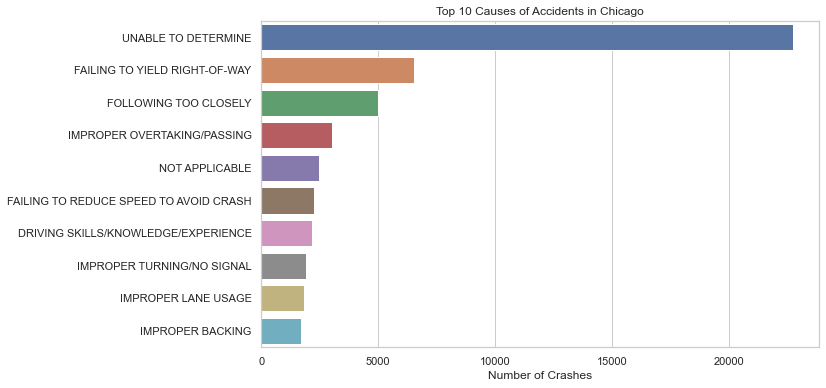

In [152]:
sns.set_theme(style="whitegrid")
# Plot the Top 10 Causes
plt.figure(figsize=(10, 6))
top_causes = data['PRIM_CONTRIBUTORY_CAUSE'].value_counts().nlargest(10)
sns.barplot(x=top_causes.values, y=top_causes.index)
plt.title('Top 10 Causes of Accidents in Chicago')
plt.xlabel('Number of Crashes')
plt.show()

Most common age of drivers involved in accidents?


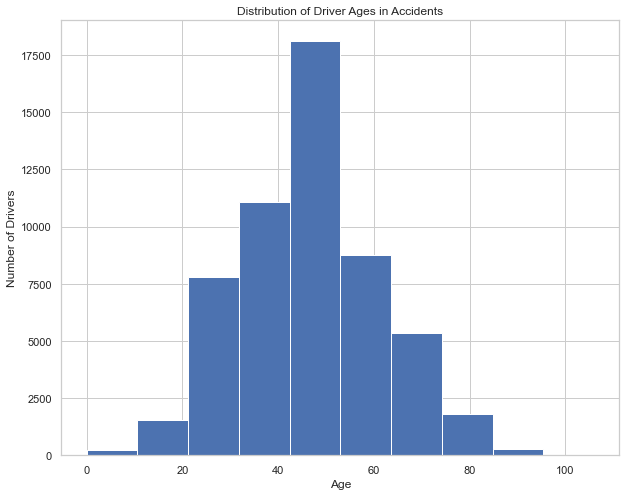

In [153]:
fig,ax = plt.subplots(figsize=(10,8))
plt.hist(data['AGE'])
plt.title('Distribution of Driver Ages in Accidents')
plt.xlabel('Age')	
plt.ylabel('Number of Drivers')
plt.show()

Number of accidents in certain hours of the day

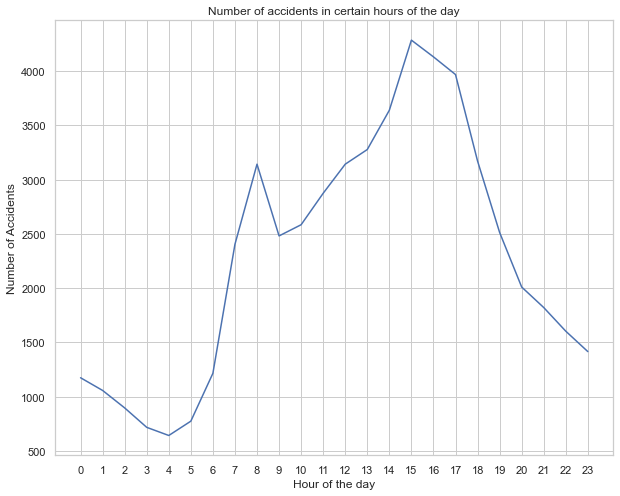

In [154]:
fig, figure= plt.subplots(figsize=(10,8))
plt.plot(data["CRASH_HOUR"].value_counts().sort_index())
plt.xlabel("Hour of the day")
plt.xticks(np.arange(24)) 
plt.ylabel("Number of Accidents")
plt.title("Number of accidents in certain hours of the day")
plt.show()

Many accidents occurred at the 15th hour (3pm) of the day. 

Why accidents peak at this hour? Is it because of traffic congestion during this time?people, and charges.

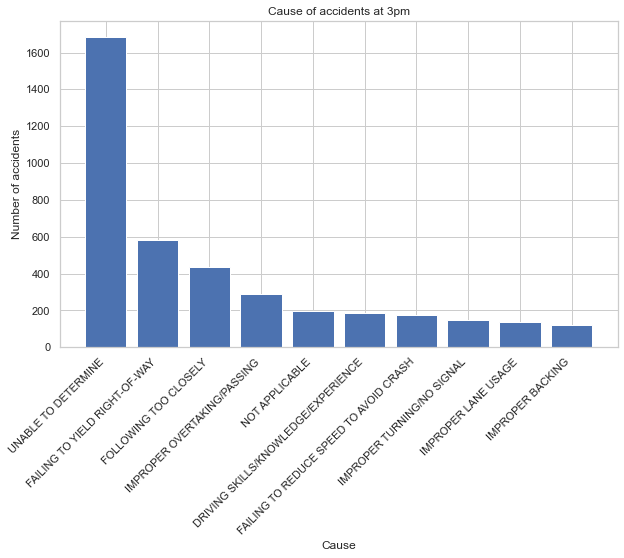

In [155]:
plt.figure(figsize=(10, 6))
pm3_accidents = data[data["CRASH_HOUR"] == 15]
cause_counts = pm3_accidents["PRIM_CONTRIBUTORY_CAUSE"].value_counts().sort_values(ascending=False).head(10)	
plt.bar(x=cause_counts.index, height=cause_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Cause")
plt.ylabel("Number of accidents")
plt.title("Cause of accidents at 3pm")
plt.show()


CORRELATION BETWEEN	AGE AND SEVERITY OF ACCIDENTS

<AxesSubplot:>

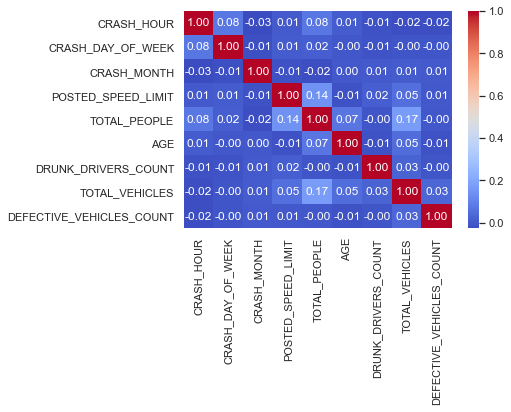

In [156]:
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")

In [157]:
data["WEATHER_CONDITION"].unique()

array(['SNOW', 'UNKNOWN', 'CLEAR', 'FOG/SMOKE/HAZE',
       'FREEZING RAIN/DRIZZLE', 'OTHER', 'BLOWING SNOW',
       'CLOUDY/OVERCAST', 'RAIN', 'SLEET/HAIL',
       'BLOWING SAND, SOIL, DIRT', 'SEVERE CROSS WIND GATE'], dtype=object)

In [158]:
def group_crash_causes(cause):
    cause = str(cause).upper()
    
    # 1. Aggressive / Rule Breaking
    if any(word in cause for word in ['SPEED', 'YIELD', 'FOLLOWING', 'TRAFFIC SIGNALS', 'RED LIGHT', 'IMPROPER', 'PASSING', 'WRONG WAY']):
        return 'Aggressive/Rule Breaking'
    
    # 2. Driver Condition (Impairment/Distraction)
    elif any(word in cause for word in ['ALCOHOL', 'DRUGS', 'DISTRACTION', 'PHONE', 'ASLEEP', 'FATIGUE', 'ILLNESS', 'TEXTING']):
        return 'Driver Condition/Distraction'
    
    # 3. Environmental / External
    elif any(word in cause for word in ['WEATHER', 'SURFACE', 'VISIBILITY', 'ANIMAL', 'EVASIVE', 'OBSTRUCTION', 'ROAD']):
        return 'Environmental/External'
    
    # 4. Vehicle Condition
    elif any(word in cause for word in ['EQUIPMENT', 'BRAKES', 'TIRES', 'LIGHTS']):
        return 'Vehicle Failure'
    
    # 5. Unknown / Vague (The 'Safety Board' should know about these separately)
    else:
        return 'Unknown/Other'

# Create the new target
data['TARGET_GROUP'] = data['PRIM_CONTRIBUTORY_CAUSE'].apply(group_crash_causes)

# Let's see how much better the distribution looks!
print(data['TARGET_GROUP'].value_counts())

Unknown/Other                   29139
Aggressive/Rule Breaking        23666
Environmental/External           1033
Driver Condition/Distraction      819
Vehicle Failure                   302
Name: TARGET_GROUP, dtype: int64


In [159]:
# List of text columns that need to be turned into numbers
categorical_cols = ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 
                    'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', "TRAFFIC_CONTROL_DEVICE"]

# X is everything EXCEPT the target columns and the ID
X = data.drop(columns=['PRIM_CONTRIBUTORY_CAUSE', 'TARGET_GROUP', 'CRASH_RECORD_ID'])

# Create X_encoded using One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols)

In [160]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# 1. Encode the new target
le_group = LabelEncoder()
y_grouped = le_group.fit_transform(data['TARGET_GROUP'])

# 2. Get your features (using the X_encoded you already made)
# X_encoded should be your features after pd.get_dummies()
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_grouped, test_size=0.2, random_state=42, stratify=y_grouped
)

# 3. Train XGBoost
xgb_grouped = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_grouped.fit(X_train, y_train)

# 4. Evaluation
y_pred = xgb_grouped.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le_group.classes_))

                              precision    recall  f1-score   support

    Aggressive/Rule Breaking       0.59      0.68      0.63      4733
Driver Condition/Distraction       0.65      0.21      0.32       164
      Environmental/External       0.32      0.09      0.14       207
               Unknown/Other       0.69      0.63      0.66      5828
             Vehicle Failure       0.44      0.28      0.34        60

                    accuracy                           0.64     10992
                   macro avg       0.54      0.38      0.42     10992
                weighted avg       0.64      0.64      0.63     10992



In [161]:
# 1. Select your Features (X)
# features = ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'LIGHTING_CONDITION', 'POSTED_SPEED_LIMIT', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'AGE', 'DRUNK_DRIVERS_COUNT', 'TOTAL_PEOPLE', 'FIRST_CRASH_TYPE', 'DEFECTIVE_VEHICLES_COUNT']

X = data.drop(columns=["PRIM_CONTRIBUTORY_CAUSE", "CRASH_RECORD_ID"])

# 2. Select your Target (y)
y = data['PRIM_CONTRIBUTORY_CAUSE']

# 3. Check what they look like
print(X.shape)
X.head()

(54959, 16)


,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,TRAFFIC_CONTROL_DEVICE,FIRST_CRASH_TYPE,TOTAL_PEOPLE,AGE,DRUNK_DRIVERS_COUNT,TOTAL_VEHICLES,DEFECTIVE_VEHICLES_COUNT,TARGET_GROUP
0,23,3,12,35,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,TRAFFIC SIGNAL,ANGLE,2,40.0,0,2,0,Aggressive/Rule Breaking
1,23,3,12,30,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,UNKNOWN,FIXED OBJECT,1,45.0,0,1,0,Unknown/Other
2,22,3,12,30,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SIDESWIPE SAME DIRECTION,2,54.0,0,2,0,Unknown/Other
3,22,3,12,35,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,STOP SIGN/FLASHER,ANGLE,4,74.0,0,2,0,Unknown/Other
4,22,3,12,30,SNOW,"DARKNESS, LIGHTED ROAD",SNOW OR SLUSH,NO DEFECTS,TRAFFIC SIGNAL,TURNING,2,39.0,0,2,0,Unknown/Other


In [162]:
data['WEATHER_CONDITION'].unique()

array(['SNOW', 'UNKNOWN', 'CLEAR', 'FOG/SMOKE/HAZE',
       'FREEZING RAIN/DRIZZLE', 'OTHER', 'BLOWING SNOW',
       'CLOUDY/OVERCAST', 'RAIN', 'SLEET/HAIL',
       'BLOWING SAND, SOIL, DIRT', 'SEVERE CROSS WIND GATE'], dtype=object)

In [163]:
# 1. Identify your text/categorical columns
categorical_cols = ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', "TRAFFIC_CONTROL_DEVICE"]
# 2. Convert text columns to numbers using One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols)
# 3. Split the data (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)
# 4. Initialize and Train the Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
# 5. Check the accuracy
accuracy = rf_model.score(X_test, y_test)
# Test set predictions
pred = rf_model.predict(X_test)
# Classification report
print(classification_report(y_test, pred))


ValueError: could not convert string to float: 'Unknown/Other'

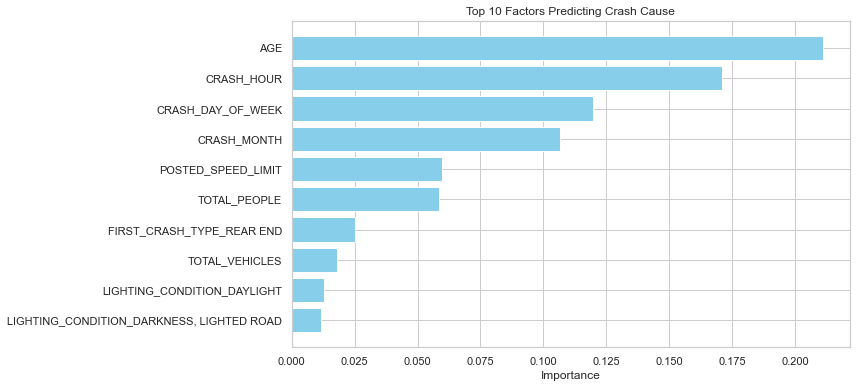

In [ ]:
# 2. Visualize Feature Importance
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the model
importances = rf_model.feature_importances_

# Create a DataFrame to view them easily
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the Top 10 Features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Factors Predicting Crash Cause')
plt.gca().invert_yaxis() # Highest importance on top
plt.show()

In [ ]:
# 1. Count occurrences of each cause
cause_counts = data['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

# 2. Identify causes that appear at least 5 or 10 times (to be safe)
valid_causes = cause_counts[cause_counts >= 5].index

# 3. Filter the dataframe
data_filtered = data[data['PRIM_CONTRIBUTORY_CAUSE'].isin(valid_causes)].copy()

# 4. Now proceed with Encoding and Splitting using data_filtered
le = LabelEncoder()
data_filtered['PRIM_CONTRIBUTORY_CAUSE_ENCODED'] = le.fit_transform(data_filtered['PRIM_CONTRIBUTORY_CAUSE'])

X = data_filtered.drop(columns=['PRIM_CONTRIBUTORY_CAUSE', 'PRIM_CONTRIBUTORY_CAUSE_ENCODED', 'CRASH_RECORD_ID'])
y = data_filtered['PRIM_CONTRIBUTORY_CAUSE_ENCODED']

# Now stratify will work!
X_train, X_test, y_train, y_test = train_test_split(
    pd.get_dummies(X), y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
# 4. Initialize the XGBoost Classifier
# use_label_encoder=False is used for newer versions of XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    objective='multi:softprob', # For multi-class classification
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# 5. Train the model
xgb_model.fit(X_train, y_train)

# 6. Evaluate
y_pred = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.4496

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        15
           4       0.17      0.01      0.02        95
           5       0.41      0.49      0.45       208
           6       0.00      0.00      0.00        67
           7       0.00      0.00      0.00        32
           8       0.00      0.00      0.00         7
           9       0.10      0.01      0.02        70
          10       0.57      0.02      0.04       438
          11       0.47      0.33      0.39        60
          12       0.00      0.00      0.00        16
          13       0.16      0.01      0.01       454
          14       0.36      0.37      0.37      1307
          15       0.44      0.55      0.49       998
          16       0.00      0.0

c:\Users\sharo\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
